In [1]:
import casadi as cas
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

# Easy Interoir Point Optimizer

Here we want to program a short and easy-to-understand "Interior Point Optimizer" for non-linear optimization problems.
Consider the following non-linear optimization problem with equality constraints $\bm{h}(\bm{x}) = 0$ and inequality constraints $\bm{g}(\bm{x}) \leq 0$.

$
\begin{equation}
    \begin{aligned}
        \textrm{min} \quad &f(\bm{x}) = x_0^4 + x_1^4 \\
        \textrm{s. t.} \quad &\bm{h}(\bm{x}) = 2x_0-x_1 = 0 \\
        &\bm{g}(\bm{x}) = 2 - x_1 \leq 0
    \end{aligned}
\end{equation}
$

In [138]:
# define programm
x = cas.SX.sym("x", 2)  # symbolic variable x
# objective function
f = x[0]**4 + x[1]**4
f_func = cas.Function(
    "f_function",
    [x],
    [f]
)
# equality constraints
h = 2*x[0] - x[1]
h_func = cas.Function(
    "eq_constraints",
    [x],
    [h]
)
g = -x[0]+2
g_func = cas.Function(
    "ineq_constraints",
    [x],
    [g]
)


### Derive KKT-Matrix

In [139]:
# calculate derivatives
# objective function
d2f = cas.hessian(f, x)
d2f_func = cas.Function(
    "function_hessian",
    [x],
    [d2f[0]]
)

# equality constraints
d2h = cas.hessian(h, x)
d2h_func = cas.Function(
    "equality_constraints_hessian",
    [x],
    [d2h[0]]
)
dh = cas.jacobian(h, x)
dh_func = cas.Function(
    "equality_constraints_jacobian",
    [x],
    [dh]
)
df = cas.jacobian(f, x)
df_func = cas.Function(
    "function_jacobian",
    [x],
    [df]
)

# inequality constraints
dg = cas.jacobian(g, x)
dg_func = cas.Function(
    "inequality_constraints_jacobian",
    [x],
    [dg]
)
d2g = cas.hessian(g, x)
d2g_func = cas.Function(
    "inequality_constraints_hessian",
    [x],
    [d2g[0]]
)

In [140]:
Gamma = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 1, 10, 50, 100, 500, 1000, 1e6, 1e9])
tol = 1e-5  # optimization tolerance to break the loop
max_iter = 1000  # maximum iterations

for gamma in Gamma:
    x_N = np.array([[50, 100]])
    nu_N = np.array([[1]])  #  how to choose the first nu ??
    lambda_N = np.array([[1]])  #  how to choose the first lambda ??
    n_iter = 0

    for k in range(max_iter):
        x_current = x_N[k]
        # evaluate function derivatives
        d2f_eval = d2f_func(x_current)
        df_eval = df_func(x_current)
        # evaluate derivatives of constraints
        d2h_eval = d2h_func(x_current)
        dh_eval = dh_func(x_current)
        # evaluate derivatives of inequaility constraints
        d2g_eval = d2g_func(x_current)
        dg_eval = dg_func(x_current)

        # create KKT-Matrix
        KKT = cas.horzcat(
            d2f_eval + d2h_eval.T * nu_N[k] + d2g_eval.T * lambda_N[k].T,
            dh_eval.T,
            dg_eval.T,
        )  # first row of matrix

        sec_row = cas.horzcat(dh_eval, 0, 0)  # second row of matrix
        third_row = cas.horzcat(-lambda_N[k] * dg_eval, 0, -g_func(x_current))
        KKT = cas.vertcat(KKT, sec_row, third_row)

        # create vector b
        b = -cas.vertcat(
            df_eval.T + nu_N[k] * dh_eval.T + lambda_N[k] * dg_eval.T,
            h_func(x_current),
            -lambda_N[k] * g_func(x_current) - 1 / gamma,
        )

        # solve linear system of equations with numpy because we really like numpy
        step = np.linalg.solve(a=KKT.full(), b=b.full())

        x_next = x_current + step[: x.shape[0]].T
        nu_next = step[x.shape[0] : x.shape[0] + nu_N.shape[1]].T
        lambda_next = step[-1:]
        x_N = np.concatenate([x_N, x_next])
        nu_N = np.concatenate([nu_N, nu_next])
        lambda_N = np.concatenate([lambda_N, lambda_next])
        n_iter += 1
        if np.abs(np.linalg.norm(x_N[k]) - np.linalg.norm(x_N[k - 1])) <= tol:
            break

    print("Optimization finished with", n_iter, "iterations.")
    print("Optimal solution found at", x_N[-1])

Optimization finished with 31 iterations.
Optimal solution found at [1.88591031 3.77182061]
Optimization finished with 1000 iterations.
Optimal solution found at [-0.08690984 -0.17381967]
Optimization finished with 1000 iterations.
Optimal solution found at [-0.04355951 -0.08711902]
Optimization finished with 1000 iterations.
Optimal solution found at [-0.03763637 -0.07527274]
Optimization finished with 1000 iterations.
Optimal solution found at [-0.02961353 -0.05922707]
Optimization finished with 1000 iterations.
Optimal solution found at [0.01998965 0.0399793 ]
Optimization finished with 1000 iterations.
Optimal solution found at [-0.34229697 -0.68459394]
Optimization finished with 58 iterations.
Optimal solution found at [-0.05547979 -0.11095959]
Optimization finished with 36 iterations.
Optimal solution found at [-0.04413458 -0.08826917]
Optimization finished with 90 iterations.
Optimal solution found at [-0.02590662 -0.05181325]
Optimization finished with 1000 iterations.
Optimal 

### Plot the results

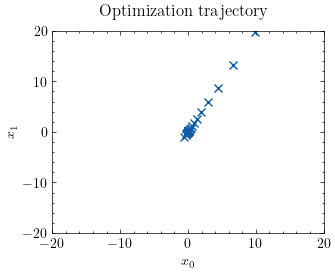

In [142]:
plt.rcParams["figure.figsize"] = (10,6)
plt.style.use('science')
fig, ax = plt.subplots(1)
fig.suptitle("Optimization trajectory")

ax.plot(x_N.T[0], x_N.T[1], "x")
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.axis([-20,20,-20,20])

# color grid
x_grid = y_grid = np.arange(-20, 20, 0.5)
grid = np.meshgrid(x_grid, y_grid)